In [1]:
# Import necessary libraries
import numpy as np  # Import NumPy for handling numerical operations
import pandas as pd  # Import Pandas for data manipulation and analysis
import warnings  # Import Warnings to suppress unnecessary warnings

# Suppress warning messages
warnings.filterwarnings("ignore")

# Import SHAP for interpreting model predictions
import shap

# Import matplotlib for data visualization
import matplotlib.pyplot as plt

# Import CatBoostRegressor for building a regression model
from catboost import Pool, CatBoostRegressor

# Import mean_squared_error for evaluating model performance
from sklearn.metrics import mean_squared_error

# Import train_test_split for splitting the data into training and testing sets
from sklearn.model_selection import train_test_split

# Import CountVectorizer from sklearn.feature_extraction.text for text feature extraction
from sklearn.feature_extraction.text import CountVectorizer

# Import ast and re for working with text and regular expressions
import ast
import re

# Set Pandas options to display a maximum of 1000 rows
pd.set_option('display.max_rows', 1000)

In [2]:
%%time
df = pd.read_csv(r'C:\Users\dell\Desktop\MyDocs\Docs\MK\2024_State_Employee_Pay.csv')
item0 = df.shape[0]  # Stores the initial number of rows in the DataFrame
df = df.drop_duplicates()  # Removes duplicate rows from the DataFrame
item1 = df.shape[0]  # Stores the number of rows after removing duplicates
print(f"There are {item0-item1} duplicates found in the dataset")  # Prints the number of duplicates that were removed
print(df.shape, df.columns)

There are 3 duplicates found in the dataset
(72865, 5) Index(['Calendar Year', 'Agency Name', 'Position Title', 'Employee Name',
       'YTD Gross Pay'],
      dtype='object')
CPU times: total: 125 ms
Wall time: 174 ms


In [3]:
df.sample(5).T

,3126,59352,16912,67887,52268
Calendar Year,2024,2024,2024,2024,2024
Agency Name,CONSERVATION,SOCIAL SERVICES,CORRECTIONS,TRANSPORTATION,PUBLIC SAFETY
Position Title,EQUIPMENT SHOP TECHNICIAN,BENEFIT PROGRAM TECHNICIAN,PROBATION AND PAROLE OFFICER,INTERMEDIATE AUDITOR,MVI ANALYST
Employee Name,"HONEYCUTT, JACK","BRYANT, LINDSEY","MERRIETT, SARAH M","GREATHOUSE, DAVID WAYNE","COALE, TOKO S"
YTD Gross Pay,48071.0,38237.1,8373.02,20837.82,30045.97


In [4]:
# Select the main label.
main_label = 'YTD Gross Pay'
# Exclude records with null compensations
df = df[~df[main_label].isnull()]
# Exclude negative and relatively small compensations
df = df[df[main_label] >= 10_000]
# Further exclude 1% of the smallest and 1% of the largest compensations
P = np.percentile(df[main_label], [1, 99])
df = df[(df[main_label] > P[0]) & (df[main_label] < P[1])]
# extract employee first name
def extract_first_name(x):
    try:
        return str(x.split(',')[-1].strip().split()[0])
    except:
        return 'None'
df['Employee Name'] = df['Employee Name'].apply(extract_first_name)
# Uppercase selected columns
for col in ['Agency Name', 'Position Title']:
    df[col] = df[col].fillna('None').str.upper()
    df[col] = df[col].apply(lambda x: x.strip())

# Drop unused columns
df.drop(['Calendar Year'], axis=1, inplace=True)

print(df.shape)  # Prints the dimensions (rows and columns) of the filtered DataFrame
df.sample(5).T  # Displays a random sample of 5 rows transposed for better visibility

(56881, 4)


,14924,5359,52209,14776,23000
Agency Name,CORRECTIONS,CORRECTIONS,PUBLIC SAFETY,CORRECTIONS,HEALTH AND SENIOR SERVICES
Position Title,FOOD SERVICE SUPERVISOR,ADMIN SUPPORT PROFESSIONAL,MOTOR VEH INSP,EDUCATION SPECIALIST,REGULATORY AUDITOR SUPERVISOR
Employee Name,JO,SARAH,JONATHAN,CATHY,MATTHEW
YTD Gross Pay,34413.46,57706.96,13795.94,54934.97,18963.0


In [6]:
!pip install -q feature_engine

In [7]:
# Import RareLabelEncoder from feature_engine.encoding for encoding categorical features
from feature_engine.encoding import RareLabelEncoder

In [8]:
# Set up a rare label encoder for selected columns.
for col in df.columns:
    if col != main_label:
        print(f"Encoding columns {col}")
        df[col] = df[col].fillna('None').astype(str)
        encoder = RareLabelEncoder(n_categories=1, max_n_categories=150, replace_with='Other', tol=20.0 / df.shape[0])
        df[col] = encoder.fit_transform(df[[col]])

print(df.shape)  # Print the shape of the resulting DataFrame.
df.sample(10).T  # Display a sample of 10 rows, transposed for easier readability.

Encoding columns Agency Name
Encoding columns Position Title
Encoding columns Employee Name
(56881, 4)


,12433,45640,69263,37971,22153,6342,39745,53653,2044,15471
Agency Name,CORRECTIONS,OFFICE OF ADMINISTRATION,TRANSPORTATION,MENTAL HEALTH,HEALTH AND SENIOR SERVICES,CORRECTIONS,MENTAL HEALTH,PUBLIC SAFETY,COMMERCE AND INSURANCE,CORRECTIONS
Position Title,CORRECTIONAL PROGRAM SPEC,Other,MAINTENANCE WORKER,SENIOR SUPPORT CARE ASSISTANT,Other,CORRECTIONAL LIEUTENANT,SUPPORT CARE ASSISTANT,SR LICENSED PRACTICAL NURSE,REGULATORY AUDITOR SUPERVISOR,MAINTENANCE/GROUNDS SUPERVISOR
Employee Name,Other,JEFFREY,Other,Other,JOSHUA,CRYSTAL,Other,BARBARA,SAMANTHA,MICHAEL
YTD Gross Pay,19067.38,95956.21,40625.92,52066.87,45554.97,50903.59,10741.62,83901.97,72499.33,50652.64


In [9]:
%%time
# Initialize data
# Extract the values of the 'main_label' column and reshape it into a 1D array as 'y'
y = df[main_label].values.reshape(-1,)

# Create the feature matrix 'X' by dropping the 'main_label' column from the DataFrame 'df'
X = df.drop([main_label], axis=1)

# Identify categorical columns in the DataFrame 'df'
# These columns contain non-numeric data
cat_cols = df.select_dtypes(include=['object']).columns

# Create a list of indices for categorical columns in the feature matrix 'X'
cat_cols_idx = [list(X.columns).index(c) for c in cat_cols]

# Split the data into training and testing sets
# - 'X_train' and 'y_train' will contain the training features and labels, respectively
# - 'X_test' and 'y_test' will contain the testing features and labels, respectively
# The split is done with a 50% test size, a random seed of 0, and stratification based on the selected column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0, stratify=df[['Employee Name']])

# Print the dimensions of the training and testing sets
# This provides insight into the sizes of the datasets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(28440, 3) (28441, 3) (28440,) (28441,)
CPU times: total: 219 ms
Wall time: 323 ms


In [10]:
%%time

# Initialize the training and testing data pools using CatBoost's Pool class
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=cat_cols_idx)  # Create a training data pool with categorical features
test_pool = Pool(X_test,
                 y_test,
                 cat_features=cat_cols_idx)  # Create a testing data pool with categorical features

# Specify the training parameters for the CatBoostRegressor model
model = CatBoostRegressor(iterations=10_000,    # Number of boosting iterations
                          depth=5,           # Maximum depth of trees in the ensemble
                          verbose=0,         # Set verbosity level to 0 (no output during training)
                          learning_rate=0.01,  # Learning rate for gradient boosting
                          early_stopping_rounds=100, # Early stopping rounds
                          loss_function='RMSE')  # Loss function to optimize (Root Mean Squared Error)

# Train the CatBoostRegressor model on the training data
model.fit(train_pool, eval_set=test_pool)

# Make predictions using the trained model on both the training and testing data
y_train_pred = model.predict(train_pool)  # Predictions on the training data
y_test_pred = model.predict(test_pool)    # Predictions on the testing data

# Calculate and print the Root Mean Squared Error (RMSE) scores for training and testing data
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)  # RMSE for training data
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)     # RMSE for testing data

# Print the rounded RMSE scores
print(f"RMSE score for train {round(rmse_train):,} USD/year, and for test {round(rmse_test):,} USD/year")

RMSE score for train 19,241 USD/year, and for test 19,545 USD/year
CPU times: total: 1min 57s
Wall time: 2min 47s


In [11]:
# Calculate the baseline RMSE (Root Mean Squared Error) scores for the training and test datasets.

# For the training dataset:

# Calculate the RMSE by comparing the actual target values (y_train) with the predicted values,
# where the predicted values are the mean of the training target values repeated for each data sample.
rmse_bs_train = mean_squared_error(y_train, [np.mean(y_train)]*len(y_train), squared=False)

# For the test dataset:

# Calculate the RMSE by comparing the actual target values (y_test) with the predicted values,
# where the predicted values are the mean of the training target values repeated for each test data sample.
rmse_bs_test = mean_squared_error(y_test, [np.mean(y_train)]*len(y_test), squared=False)

# Print the rounded baseline RMSE scores for both the training and test datasets.
print(f"RMSE baseline score for train {round(rmse_bs_train):,} USD/year, and for test {round(rmse_bs_test):,} USD/year")

RMSE baseline score for train 23,292 USD/year, and for test 23,162 USD/year


In [12]:
%matplotlib inline

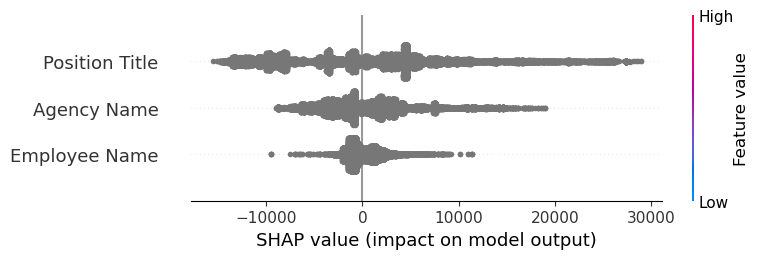

CPU times: total: 1min 19s
Wall time: 16 s


In [13]:
%%time
# Initialize the SHAP library for visualization
shap.initjs()

# Create a TreeExplainer object for the 'model' (assumes 'model' is a tree-based model like a Random Forest or XGBoost)
ex = shap.TreeExplainer(model)

# Calculate SHAP values for the 'X_test' data using the TreeExplainer
shap_values = ex.shap_values(X_test)

# Generate a summary plot to visualize the impact of features on model predictions
shap.summary_plot(shap_values, X_test)

In [14]:
# Calculate the expected values using a variable named 'ex.expected_value'.
expected_values = ex.expected_value

# Print the average predicted label
print(f"Average predicted salary is {round(expected_values):,} USD/year")

# Print the average actual label from 'y_test'
print(f"Average actual salary is {round(np.mean(y_test)):,} USD/year")

Average predicted salary is 45,952 USD/year
Average actual salary is 45,753 USD/year



Agency Name



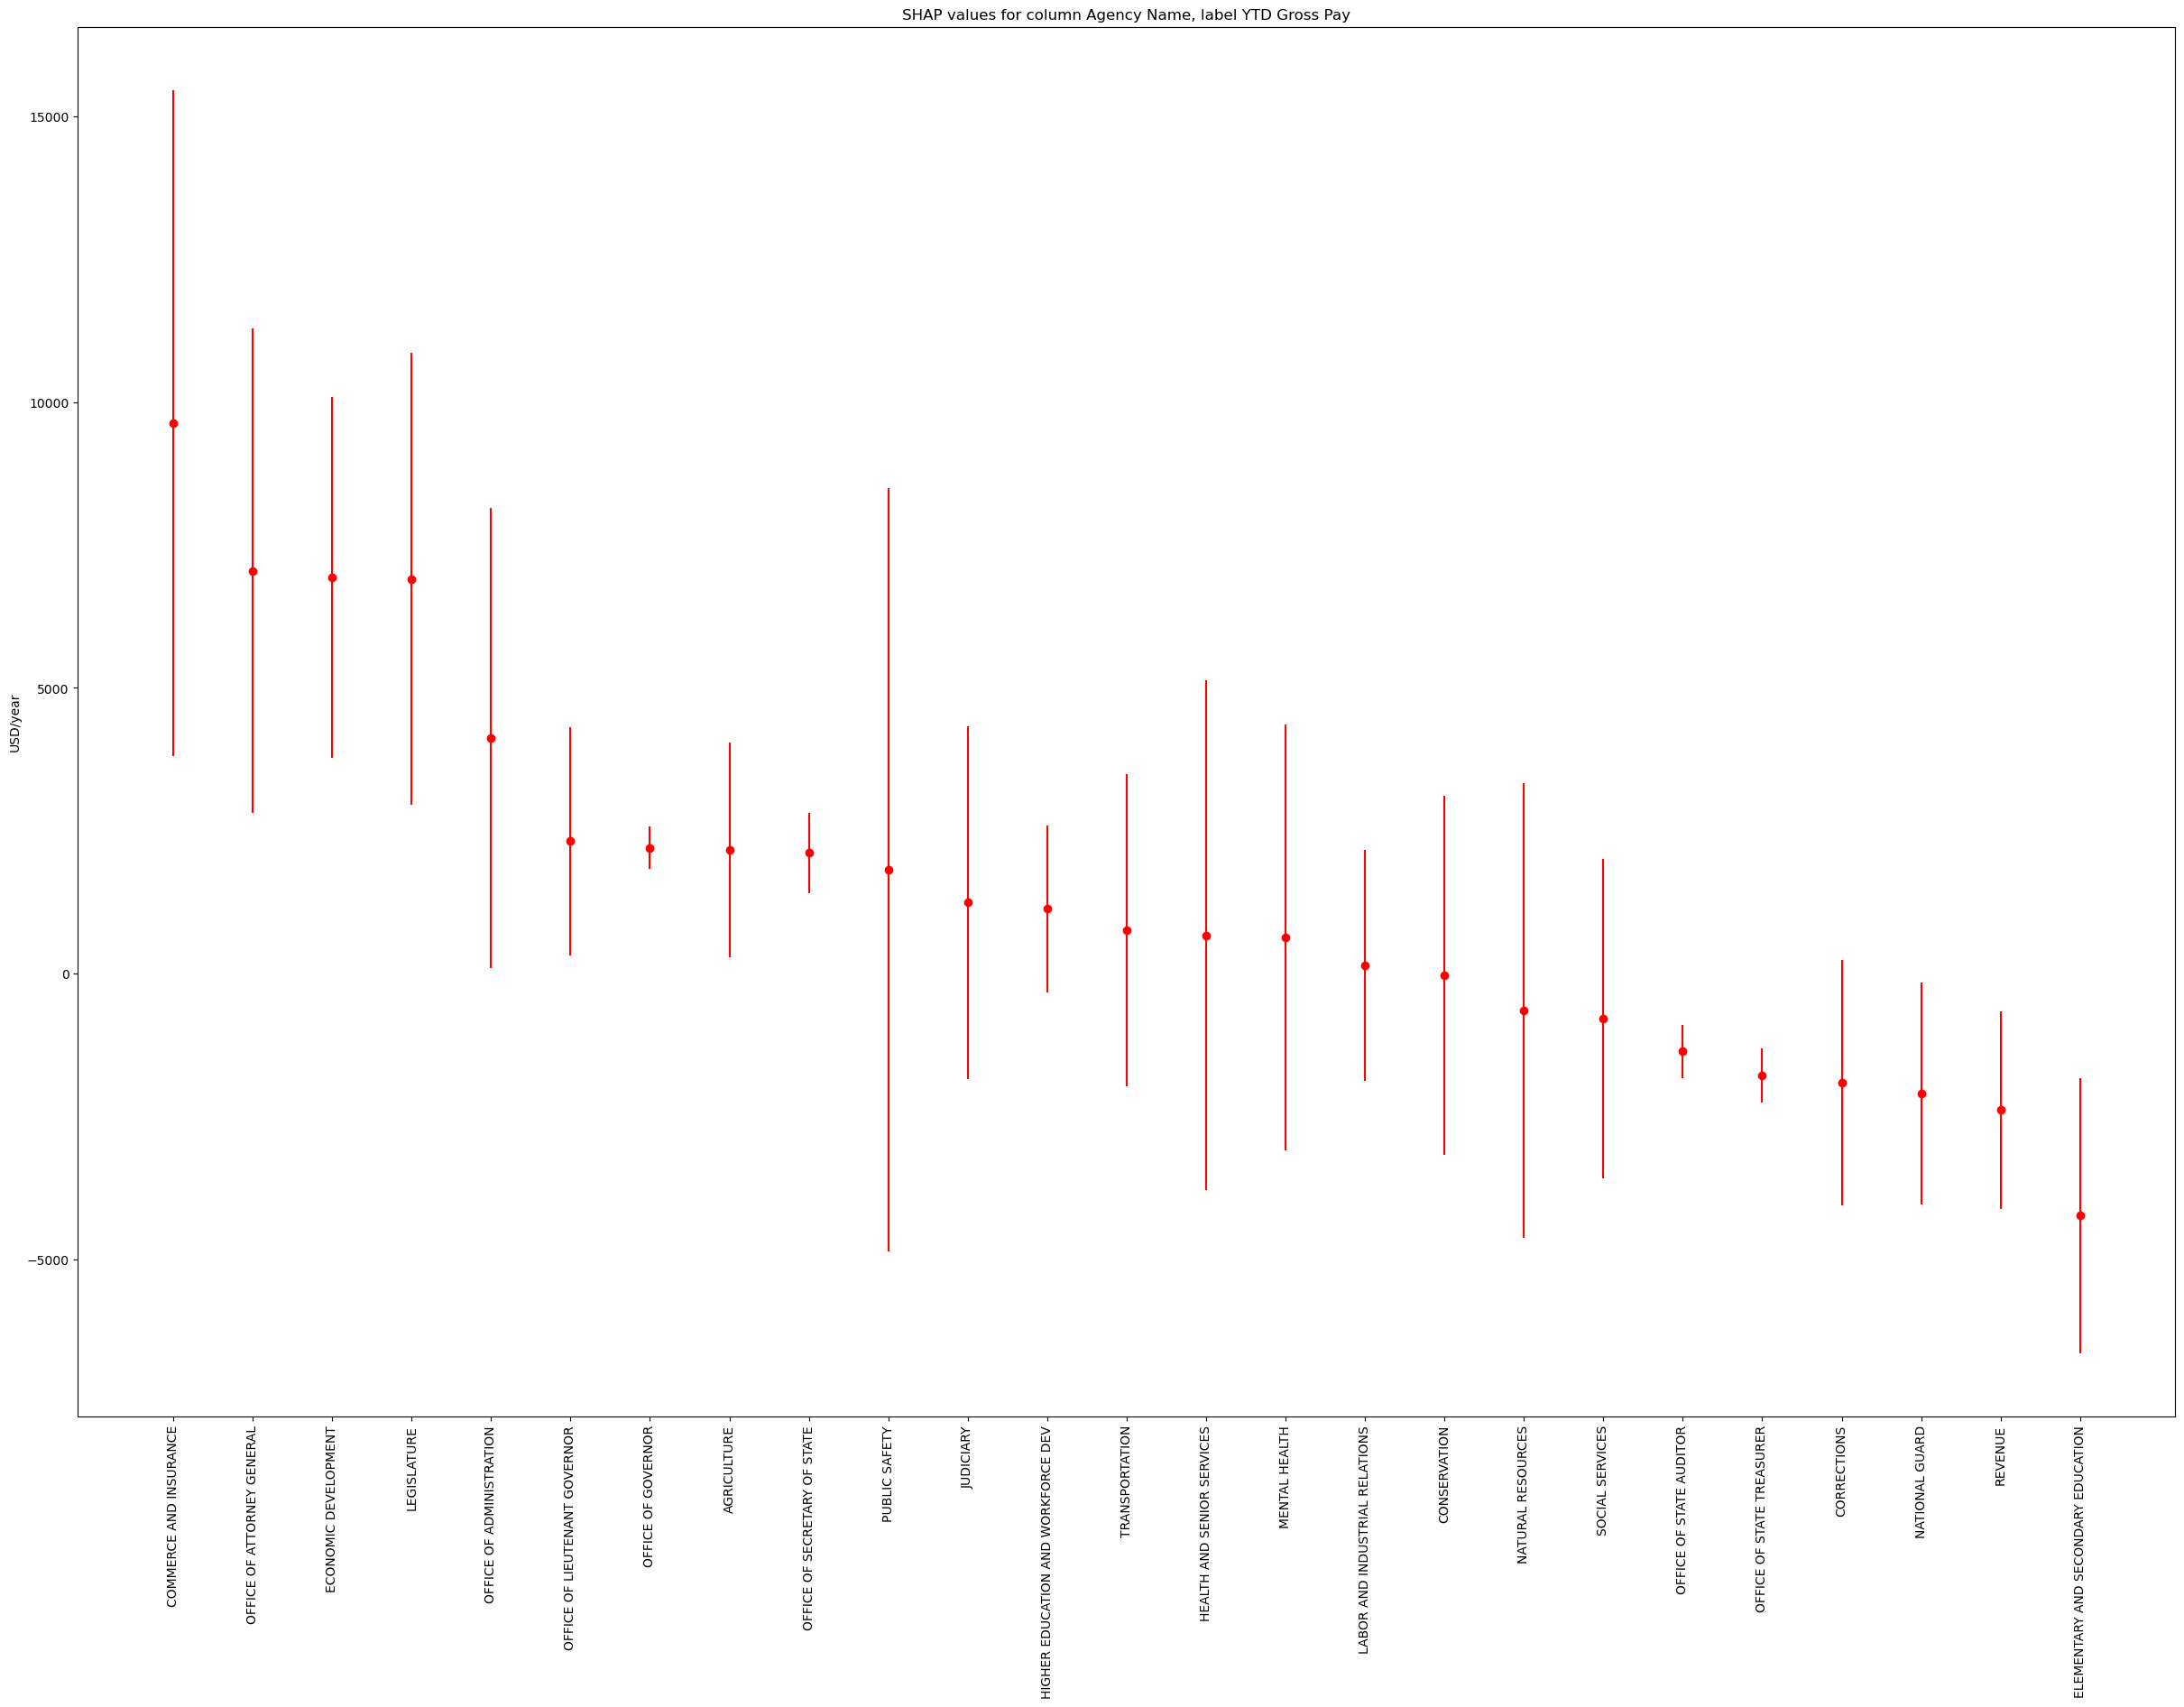

                                         gain   gain_std  count
col                                                            
COMMERCE AND INSURANCE              9633.8392  5828.5279    407
OFFICE OF ATTORNEY GENERAL          7044.4224  4234.5625    173
ECONOMIC DEVELOPMENT                6931.2666  3154.8248     94
LEGISLATURE                         6902.2296  3958.2222    316
OFFICE OF ADMINISTRATION            4116.1350  4023.4078   1098
OFFICE OF LIEUTENANT GOVERNOR       2313.3925  1993.3178     15
OFFICE OF GOVERNOR                  2197.7460   375.9545     16
AGRICULTURE                         2156.1434  1880.8466    218
OFFICE OF SECRETARY OF STATE        2107.5500   701.4258    133
PUBLIC SAFETY                       1813.0346  6682.3917   2609
JUDICIARY                           1241.3055  3088.6853   1968
HIGHER EDUCATION AND WORKFORCE DEV  1131.6052  1461.2797    171
TRANSPORTATION                       754.2734  2730.9790   2929
HEALTH AND SENIOR SERVICES           668

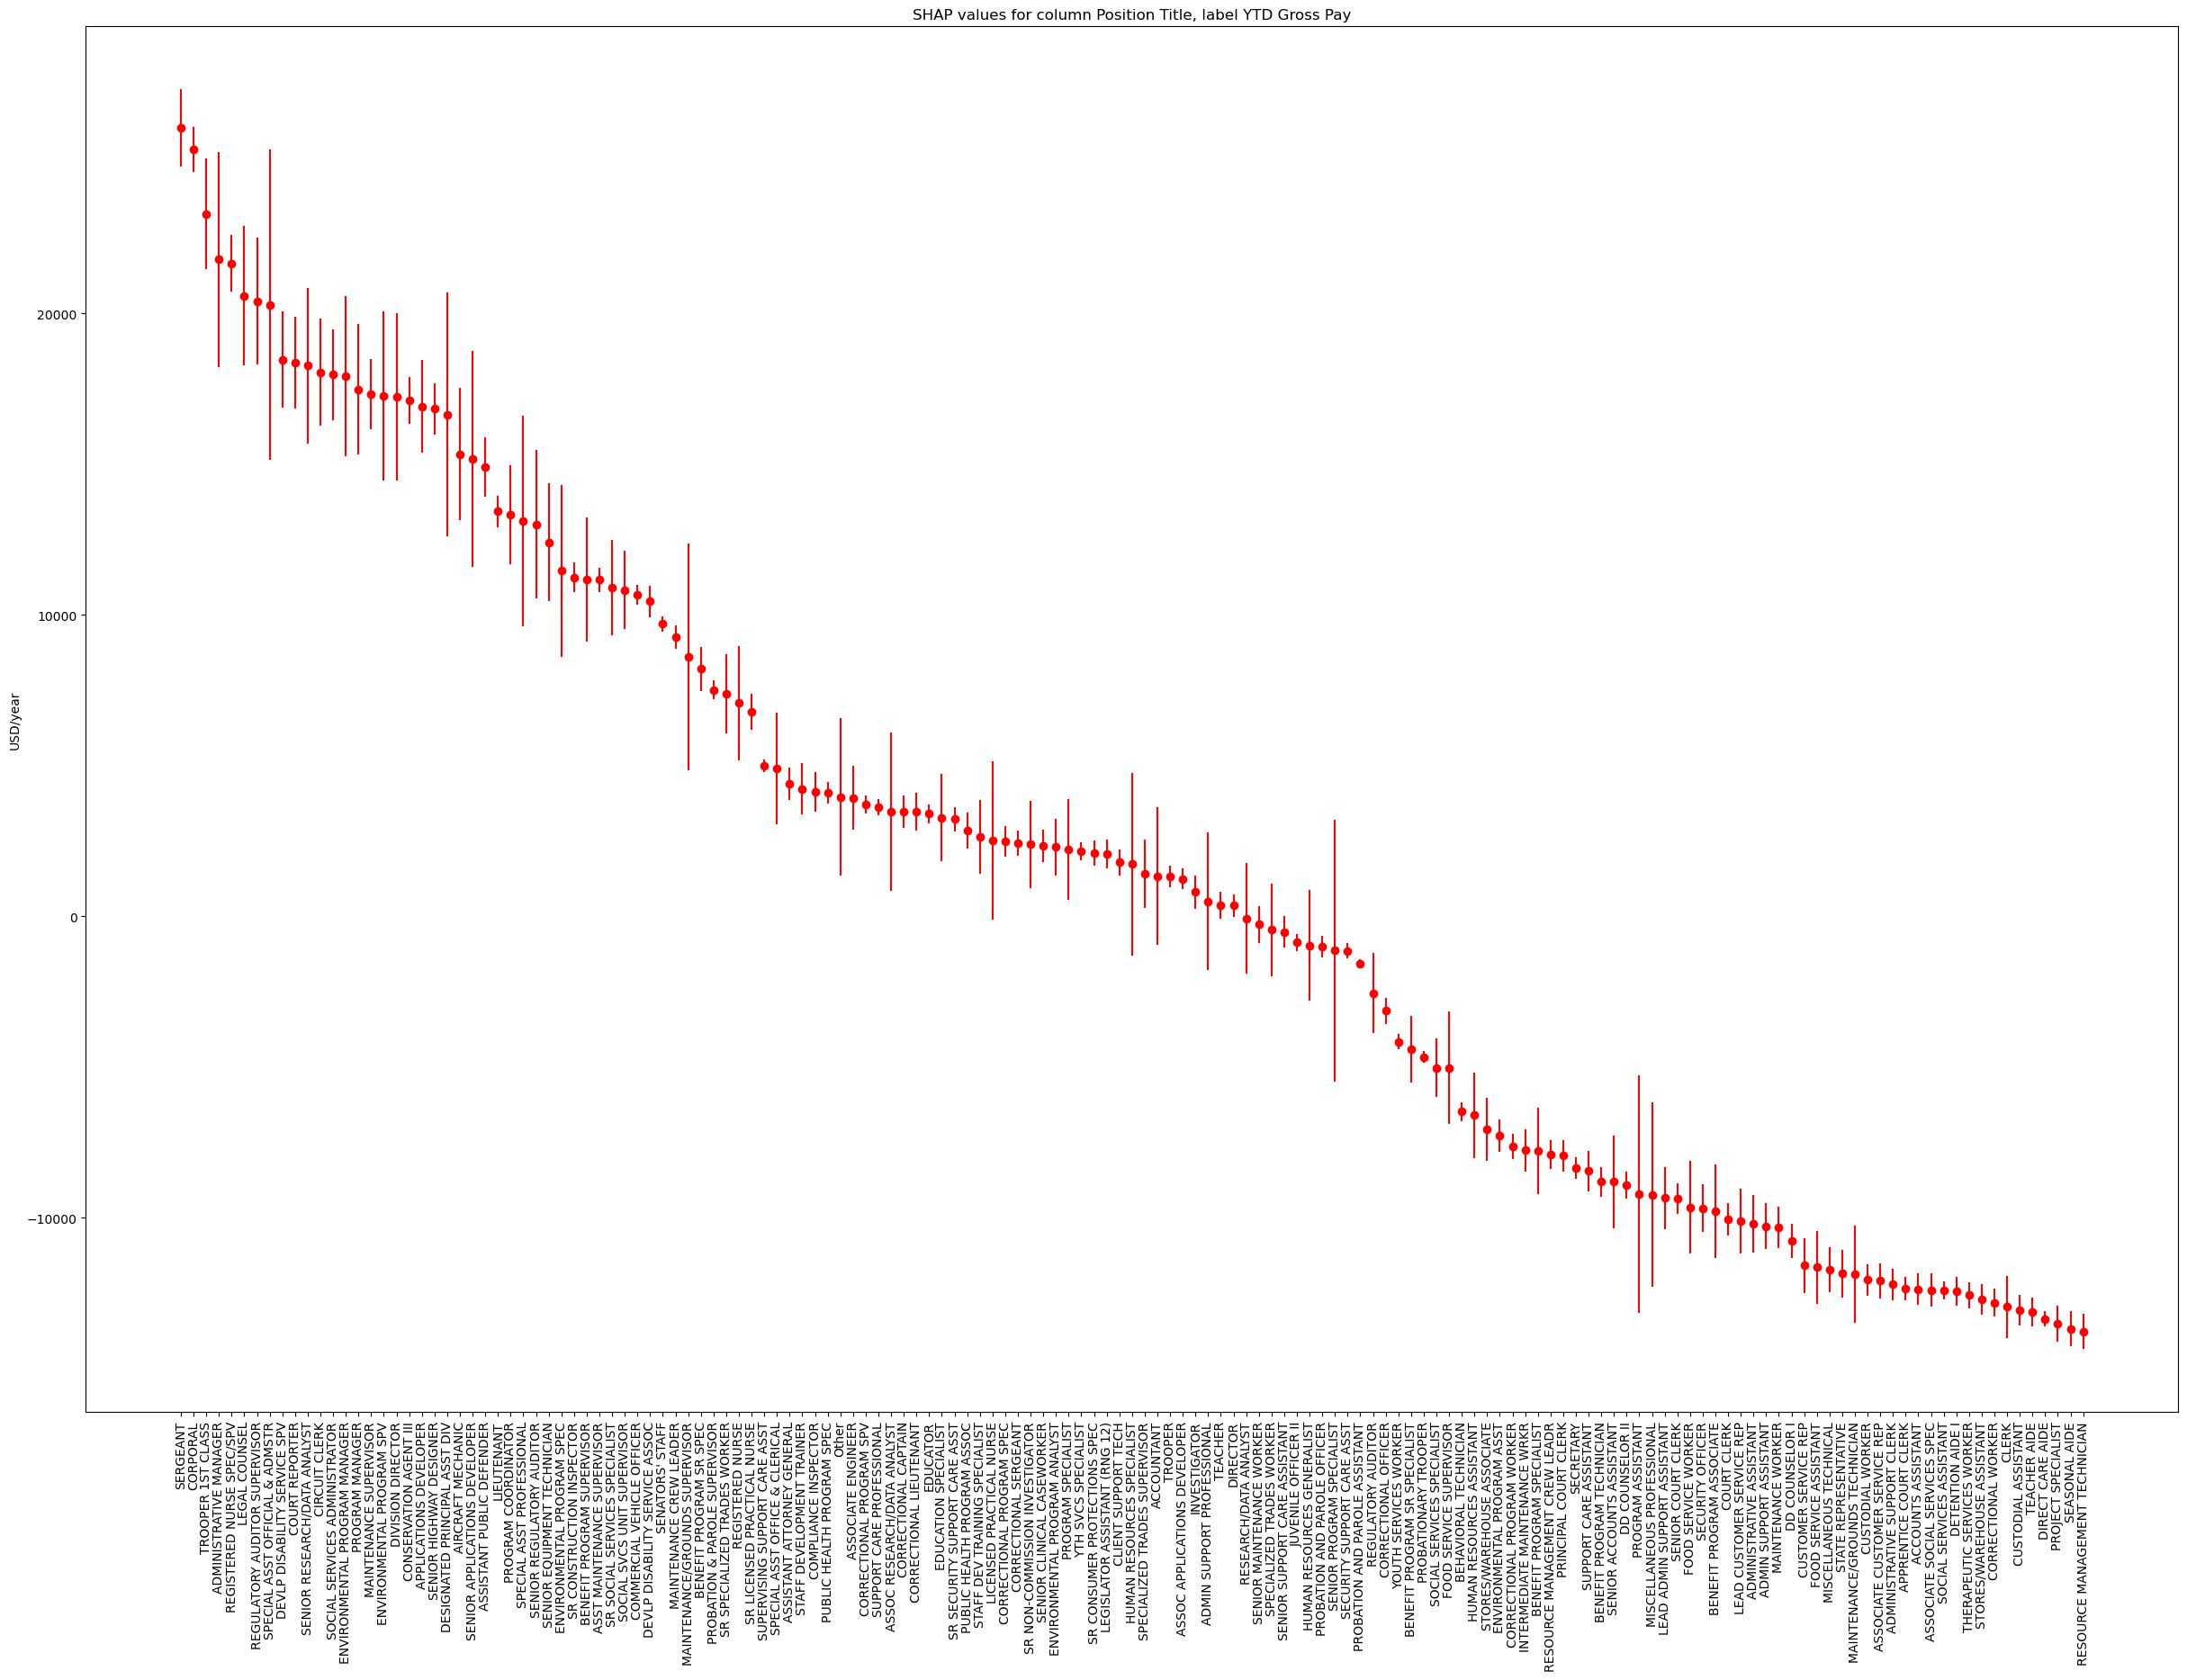

                                      gain   gain_std  count
col                                                         
SERGEANT                        26140.3004  1281.1843    148
CORPORAL                        25433.0477   748.9076    168
TROOPER 1ST CLASS               23290.2064  1838.7730    177
ADMINISTRATIVE MANAGER          21779.6081  3577.0036     67
REGISTERED NURSE SPEC/SPV       21656.6730   947.3750    112
LEGAL COUNSEL                   20584.9274  2317.6550     77
REGULATORY AUDITOR SUPERVISOR   20405.7710  2090.8159     33
SPECIAL ASST OFFICIAL & ADMSTR  20280.3323  5139.5497     39
DEVLP DISABILITY SERVICE SPV    18463.4656  1584.8721     34
COURT REPORTER                  18360.5865  1521.6522     89
SENIOR RESEARCH/DATA ANALYST    18260.1647  2575.4198     38
CIRCUIT CLERK                   18040.5991  1775.0049     59
SOCIAL SERVICES ADMINISTRATOR   17959.3882  1499.9711     32
ENVIRONMENTAL PROGRAM MANAGER   17921.2585  2650.9445     36
PROGRAM MANAGER         

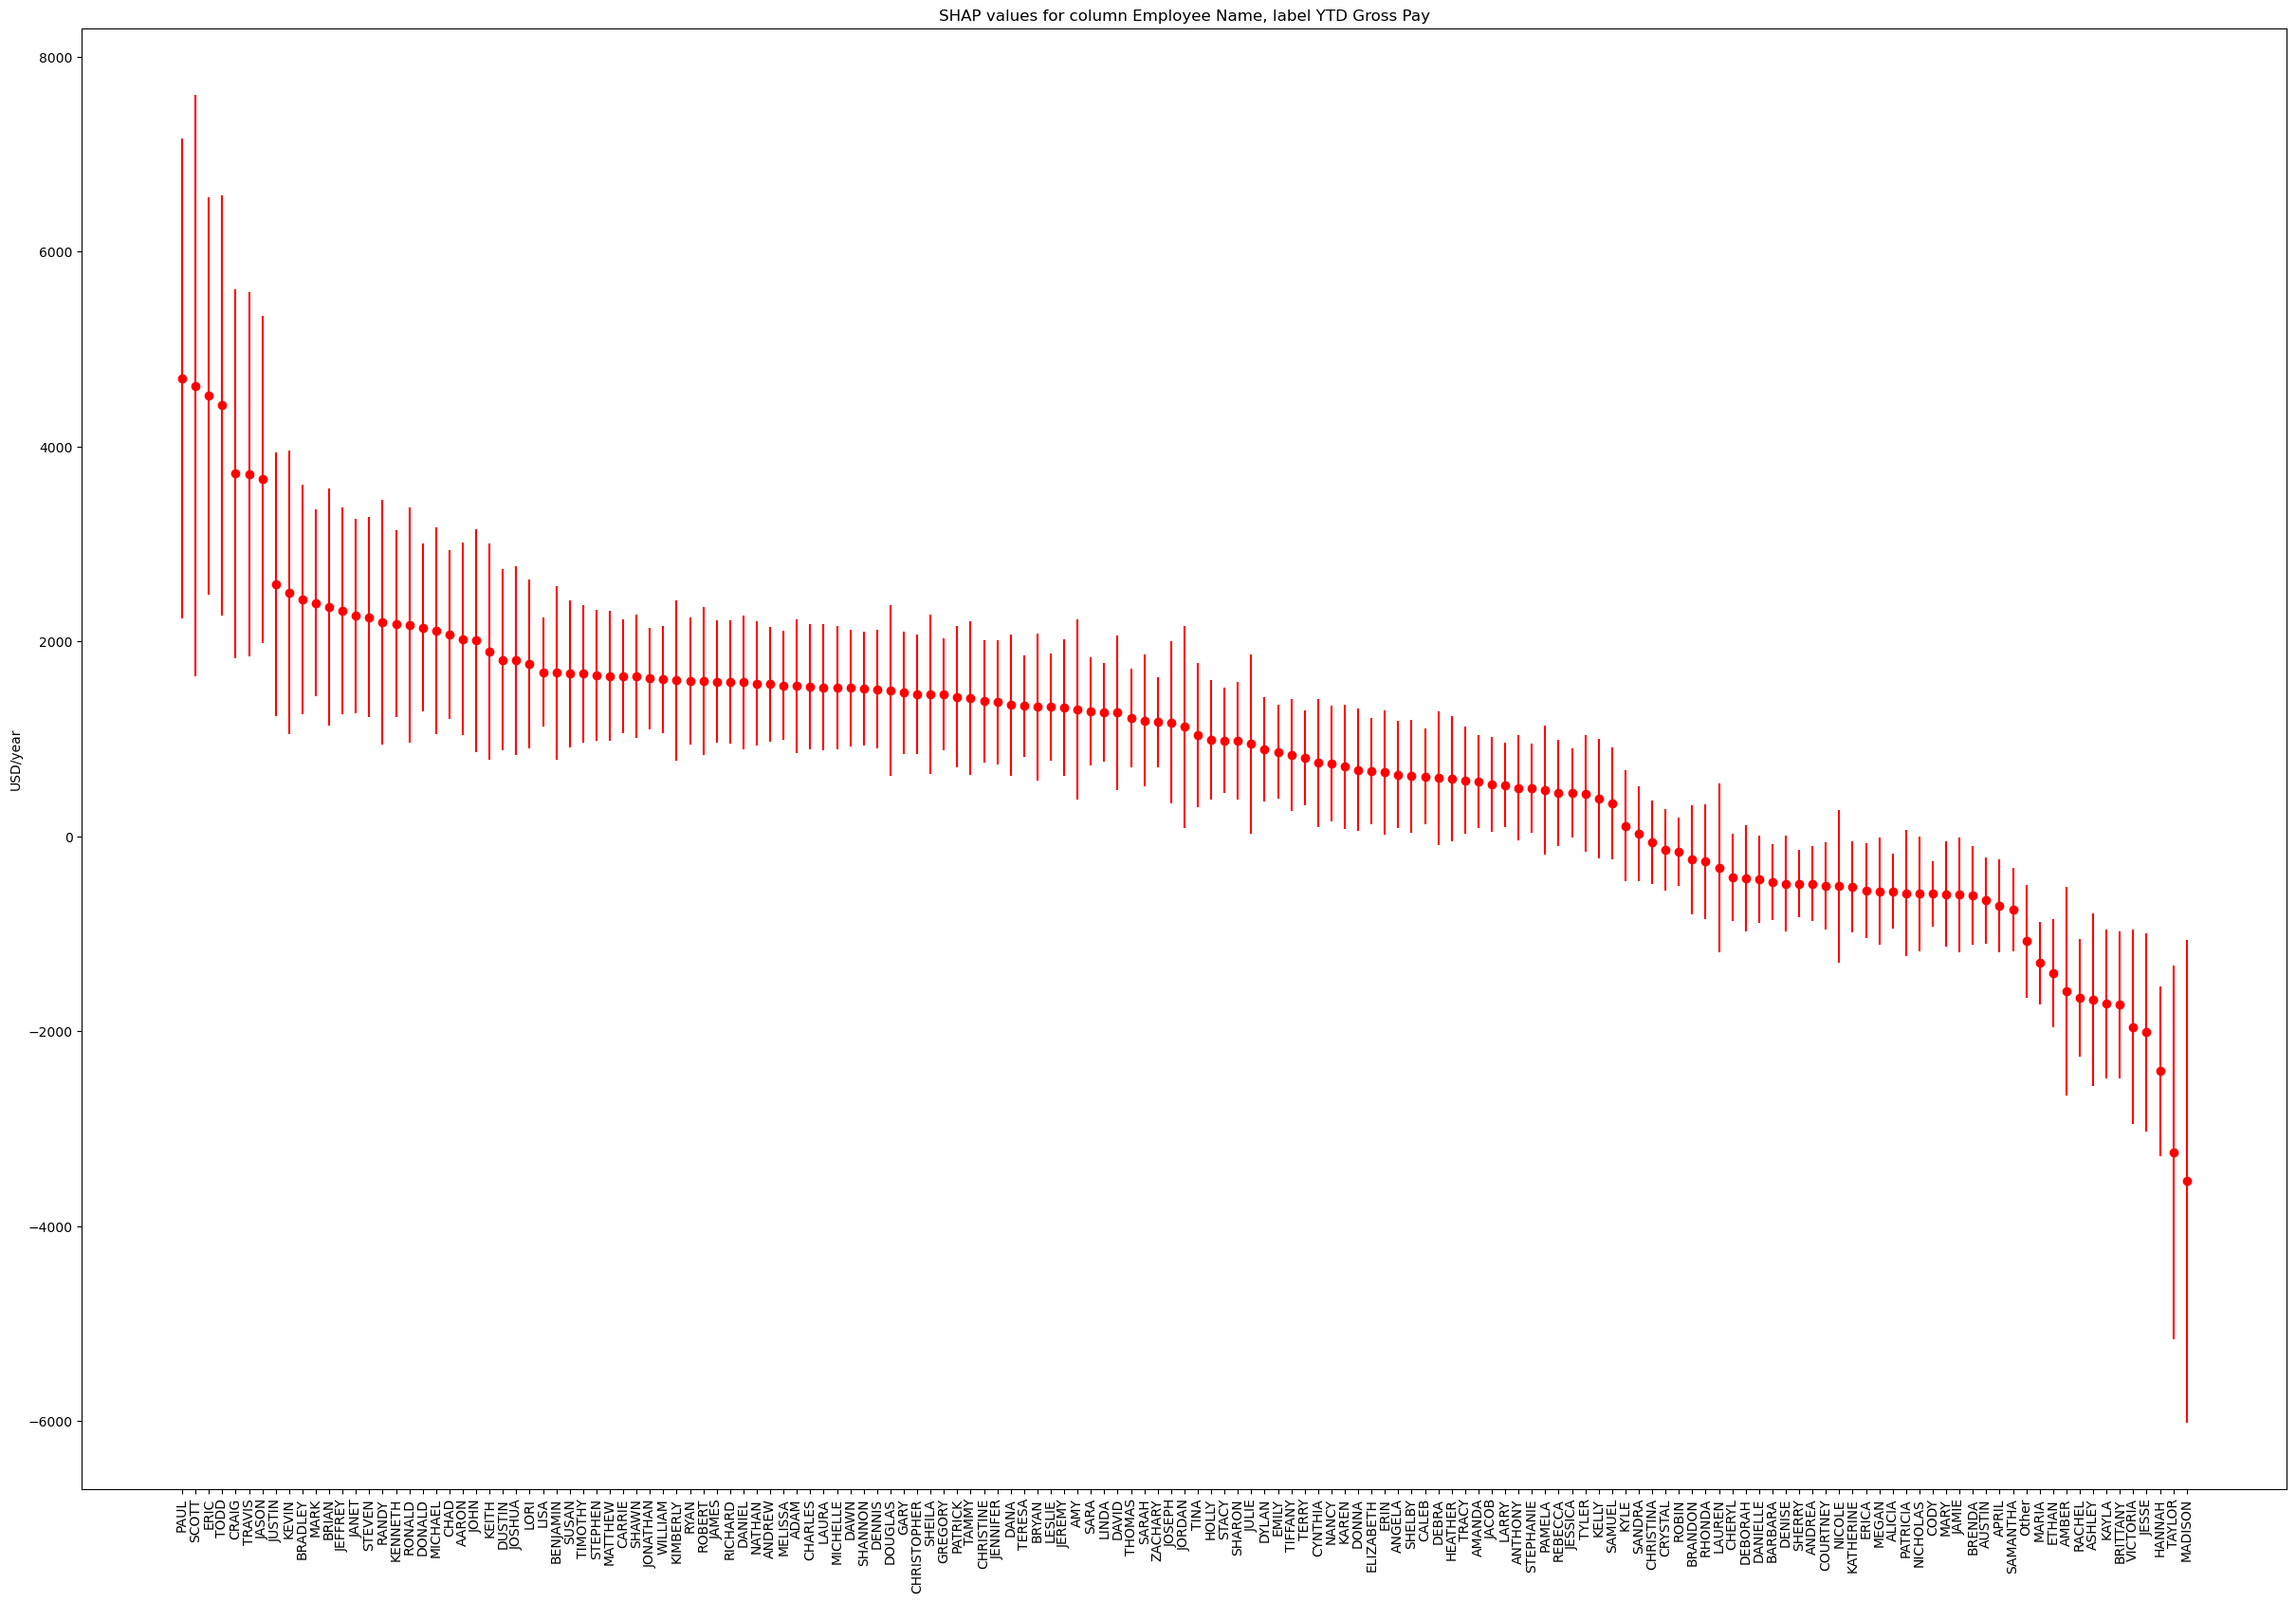

                  gain   gain_std  count
col                                     
PAUL         4699.9899  2459.6342     76
SCOTT        4623.9817  2984.8794    110
ERIC         4521.3202  2037.7667    106
TODD         4420.5460  2153.9480     38
CRAIG        3719.6582  1892.0990     44
TRAVIS       3713.3304  1870.5989     77
JASON        3663.6335  1678.7588    178
JUSTIN       2588.3989  1351.2075    137
KEVIN        2501.0725  1455.8260    137
BRADLEY      2428.0215  1176.4179     72
MARK         2395.8397   961.8868    135
BRIAN        2351.2078  1217.3044    151
JEFFREY      2314.2558  1060.4326    139
JANET        2261.6376   995.8237     42
STEVEN       2248.5421  1027.5500    121
RANDY        2198.1117  1254.8734     41
KENNETH      2180.6891   959.3130     77
RONALD       2167.2635  1206.5785     64
DONALD       2141.2107   861.4653     71
MICHAEL      2107.3681  1058.5371    402
CHAD         2066.9436   866.9880     53
AARON        2025.0861   985.2519     89
JOHN         201

In [15]:
# Define a function named 'show_shap' that visualizes SHAP values for a specific feature.
# Parameters:
#   - col: The name of the feature for which SHAP values will be visualized.
#   - shap_values: SHAP values calculated for the model's predictions.
#   - label: The label to be displayed in the plot title.
#   - X_test: The DataFrame containing the test data.
#   - ylabel: The label for the y-axis in the plot (default is 'points').
def show_shap(col, shap_values=shap_values, label=main_label, X_test=X_test, ylabel='USD/year'):
    # Create a copy of the test data DataFrame.
    df_infl = X_test.copy()

    # Add a new column 'shap_' to the DataFrame containing SHAP values for the specified feature.
    df_infl['shap_'] = shap_values[:, df_infl.columns.tolist().index(col)]
    
    # Calculate the mean SHAP values and standard deviation grouped by the specified feature.
    gain = round(df_infl.groupby(col)['shap_'].mean(), 4)
    gain_std = round(df_infl.groupby(col)['shap_'].std(), 4)
    
    # Count the number of data points for each category of the specified feature.
    cnt = df_infl.groupby(col)['shap_'].count()
    
    # Create a dictionary containing the feature, mean SHAP values, standard deviation, and count.
    dd_dict = {'col': list(gain.index), 'gain': list(gain.values), 'gain_std': list(gain_std.values), 'count': cnt}

    # Create a DataFrame from the dictionary and sort it by 'gain' in descending order.
    df_res = pd.DataFrame.from_dict(dd_dict).sort_values('gain', ascending=False).set_index('col')
    
    # Replace "$" by "*" to use in matplotlib
    if any([('$' in str(idx)) for idx in set(df_res.index)]):
        print('Replacing "$" by "*" to use in matplotlib')
        df_res.index = [c.replace('$','*') for c in df_res.index]
    
    # Create a plot to visualize the SHAP values with error bars.
    plt.figure(figsize=(30, 20))
    plt.errorbar(df_res.index, df_res['gain'].values, yerr=df_res['gain_std'].values, fmt="o", color="r")
    
    # Set plot title and axis labels.
    plt.title(f'SHAP values for column {col}, label {label}')
    plt.ylabel(ylabel)
    plt.tick_params(axis="x", rotation=90)
    
    # Display the plot and the DataFrame with results.
    plt.show()
    print(df_res)
    
    # Return the function.
    return

# Loop through the columns in the test data.
for col in X_test.columns:
    print()  # Print an empty line for better readability.
    print(col)  # Print the name of the current column.
    print()  # Print another empty line for separation.

    # Call the 'show_shap' function to visualize SHAP values for the current column.
    show_shap(col, shap_values, label=main_label, X_test=X_test)